In [1]:
import sys
import time
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt
from matplotlib import rc

from garipov_deconvolution import get_coeff_simpson, Gold

Минимальная энергия: 1e-3
windows (w) or linux (l): w


In [106]:
font_properties = {'family' : 'Arial', 'weight' : 'regular', 'size' : 14}
rc('font', **font_properties)

Создание энергетических спектров

In [107]:
linspace1 = np.linspace(0.035, 0.1, 25, dtype=np.float32)
linspace2 = np.geomspace(0.11, 3, 25, dtype=np.float32)

# список энергий пучков электронов
beams_energyes = []
beams_energyes.extend(linspace1)
beams_energyes.extend(linspace2)
beams_energyes = np.array(beams_energyes)

In [108]:
# зарядовые числа материалов мишеней
z_numbers = np.array([i for i in range(1, 101)])

In [109]:
def initialization_brem(material_z, beam_energy, tick=0.01):
    """
    Функция принимает материал мишени и энергию налетающего 
    электронного пучка
    Возвращаемое значение: генерируемый тормозной спектр
    """
    
    coefficient = Material(material_z).M()/material_z
    target = R(Material(material_z), tick*coefficient)
    bremsstrahlung = target.brem_mass(beam_energy)
    bremsstrahlung_en = bremsstrahlung * en
    
    return np.array(bremsstrahlung_en)

Построение энергетического спектра

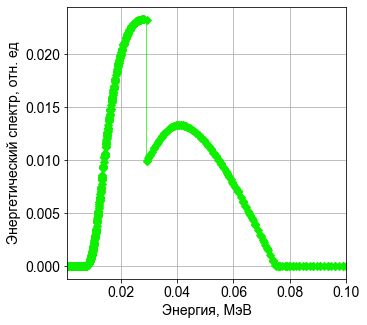

In [110]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(en, initialization_brem(50, 0.075), ls='-', marker='D', lw='0.7', ms=5, color='#0FF000')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

# fig.savefig('Название_1.jpg', bbox_inches='tight')

Определение функций для создания матрицы спектров

In [111]:
def generate_empty_matrix(num_row, num_col):
    """
    Функция создает пустую матрицу заданных размеров
    Возвращает вложенный список
    """
    empty_matrix = [[[] for j in range(num_col)] for i in range(num_row)]
    return empty_matrix


def complete_empty_matrix(empty_matrix, array_1, array_2, func):
    """
    Функция заполняет пустую матрицу заданными элементами из массивов
    array_1, array_2 по правилу, определяемому функцией fucn.
    Возвращает заполненную матрицу np.ndarray
    """
    for row, val_1 in enumerate(array_1):
        for col, val_2 in enumerate(array_2):
            empty_matrix[row][col] = func(val_1, val_2)
            
    return np.array(empty_matrix)

Создание трехмерной матрицы спектров

In [112]:
# создание матрицы со всеми сгенерированными спектрами
empty_bremsstrahlungs_matrix = generate_empty_matrix(len(z_numbers), len(beams_energyes))
bremsstrahlungs = complete_empty_matrix(empty_bremsstrahlungs_matrix, z_numbers, beams_energyes, initialization_brem)

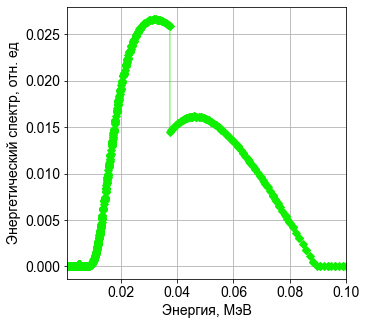

In [113]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(en, bremsstrahlungs[55][20], ls='-', marker='D', lw='0.7', ms=5, color='#0FF000')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

# fig.savefig('Название_2.jpg', bbox_inches='tight')

Создание списка К скачоков и добавление скачков, необходимых для учета при восстановлении

In [114]:
# материал первого фильтра 
n = 11

In [115]:
# Индексы К скачков
EDGES = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGES.append(i - 1)
        

def add_edges_to_mesh(material):
    EDGES.remove(EDGES[EDGES.index(Material(material).k_index())])

In [116]:
add_edges_to_mesh(50)

Инициализация измерительных каналов

In [117]:
def rectangle_ideal(grid, material_num_1, material_num_2):
    signal = R(Material(1), 1).f()
    signal[:] = 0
    signal[Material(material_num_1).k_index() + 1:Material(material_num_2).k_index() + 1] = 1
    return signal

K = [Material(i).k_index() for i in range(11, 101)]
K.append(0)
resp_rectangle = [rectangle_ideal(en, i, i+1) for i in range(11, 100)]

Измерение спектра

In [118]:
brem_e = bremsstrahlungs[49][15]

In [138]:
# вычисление среднего значение энергии в полосах пропускания измерительных каналов
left_bounds = [Material(i).k_en() for i in range(11, 100)]
right_bounds = [val for val in left_bounds]
mean_energy_in_pass_band = (np.array(right_bounds) + np.array(left_bounds)) / 2


# интегральные сигналы измерительных каналов
signals_simpson = [sum(get_coeff_simpson(brem_e*r, en, EDGES)[0]) for r in resp_rectangle]
# среднее значение измеренного спектра
mean_spectrum = np.array(signals_simpson) / mean_energy_in_pass_band

In [ ]:
signals_number = len(signals_simpson)

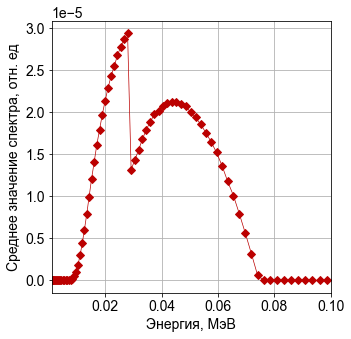

In [139]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(mean_energy_in_pass_band, signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='#BB0000')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Среднее значение спектра, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

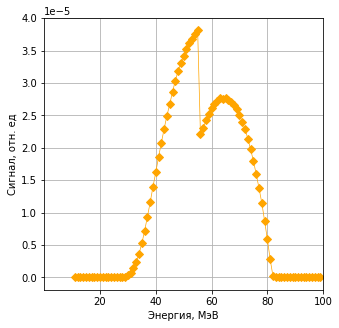

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(range(n, 100), signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e+2)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Восстановление спектра

In [141]:
# создание матрицы задачи
Matrix = [get_coeff_simpson(response, en, EDGES)[0] for response in resp_rectangle]

In [81]:
sp = np.array([np.nan for i in range(signals_number)])
norm = np.array([np.nan for i in range(signals_number)])
decb = np.array([np.nan for i in range(signals_number)])
dev = np.array([np.nan for i in range(signals_number)])

new_en = get_coeff_simpson(resp_rectangle[0], en, EDGES)[1]

In [82]:
import time
# восстановление спектра методом Голда на основании К-фильтров
start_time = time.time()
sp, norm, dev = Gold(Matrix, signals_simpson, en, brem_e, new_en, 1, 10000, w=True, d=False)[:3]
print(round(time.time()-start_time, 6))

4.177653


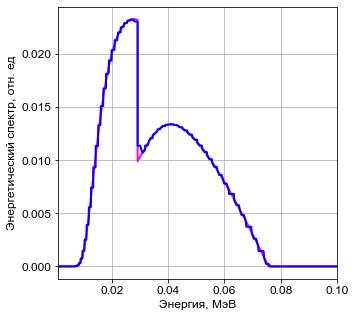

In [84]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(en, brem_e, ls='-', lw='2', ms=5, color='magenta')
ax.plot(new_en, sp, ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)